# Basic Usage of ase_uhal

The ase_uhal package implements various tools for enabling HAL-style biased dynamics to accelerate active learning workflows.

First, some imports:

In [27]:
# Imports
from mace.calculators import mace_mp
from ase.build import bulk
from ase.atoms import Atoms
import matplotlib.pyplot as plt
import numpy as np
from ase.md.langevin import Langevin
from ase.units import fs
from tqdm import tqdm, trange
from docs_vis import interactive_view

In [28]:
from ase_uhal.bias_calculators import HALBiasCalculator
from ase_uhal.committee_calculators import MACEHALCalculator
from ase_uhal import StructureSelector

## Committee Calculators
ase_uhal computes a biasing potential based on an error metric from a zero-mean committee of linear models based on a descriptor function. The first step is to generate this committee. This is managed by several variants of the committee calculator interface. Here, we use `MACEHALCalculator`, which implements a HAL-style biasing potential (based on the standard deviation of the committee energies) using MACE descriptor features (equivalent to `mace_calc.get_descriptor()`). We will take these features from the MPA medium foundation model:

In [29]:
mace_calc = mace_mp() # normal MACE MPA medium model calculator (from mace_torch)

comm_calc = MACEHALCalculator(mace_calc, 
                                    committee_size=20,
                                    prior_weight=0.1, # Weight of the prior in the linear system to find committee weights
                                    energy_weight=1, forces_weight=100, # Weights on energy and force observations when sampling new structures
                                    lowmem=False, # Use a lower memory strategy to fit the linear system
                                    rng=np.random.RandomState(42))

comm_calc.resample_committee() #Build the initial committee 

Using medium MPA-0 model as default MACE-MP model, to use previous (before 3.10) default model please specify 'medium' as model argument
Using Materials Project MACE for MACECalculator with /home/u2180064/.cache/mace/macempa0mediummodel
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Using head default out of ['default']
Default dtype float32 does not match model dtype float64, converting models to float32.


/home/u2180064/.local/lib/python3.10/site-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


The `MACEHALCalculator` object internally manages the committee state, and uses the standard ASE calculator interface. The committee is zero-mean by construction, so the energies, forces, and stresses calculated by the committee are not intended to be used as a standalone interatomic potential. We use special "bias_" properties (e.g. "bias_energy") to differentiate properties of the committee which should be used for biasing.

In [30]:
ats = bulk("Si", cubic=True)
ats.calc = comm_calc

print(ats.get_potential_energy(), comm_calc.get_property("bias_energy", ats))

-7.5905275 33.967884



It is important to also be able to update the committee once we have found a structure we want to add to the database. We can do this using the `select_structure()` method:

In [31]:
ats = bulk("Si", cubic=True)
comm_calc.select_structure(ats) # Adds a silicon bulk structure to the list of selected structures

# Resample the committee, now incorporating information from the newly selected structure
comm_calc.resample_committee()

Selecting a structure does two main things. Firstly, it adds a copy of the structure to the `selected_structures` list of the calculator object, so that the selected structures can be easily retrieved later on (e.g. after the biased dynamics has finished). Secondly, it adds the features of the structure (descriptor evaluations and their gradients) to an internal linear system, so that future committee samples are conditioned on this new information. 

The second part is important, as it reduces the committee variance for structures close to the sampled structure. In this way, we learn to avoid the previously sampled space, and can more easily sample new regions.

## Bias Calculators
The bias calculators combine a standard ase-compatible calculator with a committee calculator described above. The result is a new ase calculator, where the energy force and stress properties are a weighted sum of the results from both component calculators:

$$\begin{equation}
    E_\text{bias} = E_\text{Normal calc} + \tau E_\text{Committee calc}
\end{equation}$$
The parameter $\tau$ describes the mixing strength, and can be either fixed or adaptively determined, in the same manner as the ACEHAL approach.

In [32]:
hal_calc = HALBiasCalculator(mean_calc=mace_calc, # Mean function calculator (replaces the mean of an ACEHAL committee)
                         committee_calc=comm_calc, # Committee biasing calculator
                         adaptive_tau=True, # Automatically control the biasing strength during dynamics
                         tau_rel=0.1, # Target ratio of bias forces to mean forces
                         tau_hist=10, # History length for force mixing to determine tau
                         tau_delay=30) # Number of mixing steps before tau should start to be changed

As well as the potential mixing, the bias calculator also implements a selection metric, which can be based on both the biasing potential or the normal ASE calculator results. The `HALBiasCalculator` class implements the same selection metric ase ACEHAL, which is based on the ratio of forces from both calculators.

We can now use the `HALBiasCalculator` as a normal ASE calculator by setting a tau value:

In [33]:
ats = bulk("Si")

ats.calc = mace_calc
print("MACE MPA Energy:", ats.get_potential_energy())

ats.calc = hal_calc
hal_calc.tau = 0.15

print("Biased Energy:", ats.get_potential_energy())

MACE MPA Energy: -10.824769973754883
Biased Energy: -10.868062588572503


## Running Biased Dynamics

We will use the example of an oxygen interstitial atom in bulk silicon as a first example of using biased dynamics with ase_uhal. We start by constructing a supercell of Si, and adding an oxygen atom into the supercell.

In [34]:
Si = bulk("Si", cubic=True)

inter_pos = np.array([0.5, 0.25, 0.25]) * Si.cell[0, 0]

ats = Si * (2, 2, 2) + Atoms("O", positions=[inter_pos])

In [35]:
interactive_view(ats)

NGLWidget(layout=Layout(height='300px', width='100%'))

In [36]:
# Setup dynamics
ats.calc = hal_calc
hal_calc.tau = 0 # Reset tau to zero, so that it can be automatically determined


# Setup MD
dyn = Langevin(ats, 1*fs, temperature_K=300, friction=0.01 / fs)


In addition to the committee and bias calculators, ase_uhal also provides functionality for attaching common processes to dynamics, using observers, so that they can be automatically handled on the fly. This can be achieved using `dyn.attach(f, interval, *args)`, where `f` is the function to be executed, `interval` is the number of MD timesteps between each call to `f`, and `*args` are arguments to `f`. 

The bias calculators allow for the biasing constant $\tau$ to be automatically determined, in a manner similar to the original ACEHAL implementation. This is directly attachable (e.g. `dyn.attach(hal_calc.update_tau, 1)` or equivalently `dyn.attach(hal_calc.update_tau)`).

### StructureSelector
StructureSelector is another attachable component which aims to automate the selection of new structures into the dataset, based on the selection scores calculated by the bias calculator. It is able to adabtively set a selection threshold by first computing a mixed score from all previous selection scores
$$\begin{equation}
    S_\text{mix}^{i} = (1 - \text{mixing}) \times S_\text{mix}^{i-1} + \text{mixing} \times S^{i}
\end{equation}$$
and then setting the selection criterion to be some user-defined multiplier of this mixed score
$$\begin{equation}
    S_\text{Criterion}^{i} = \text{thresh\_mul} \times S_\text{mix}^{i}
\end{equation}$$

Once a score beats the selection criterion, the `StructureSelector` object will wait until a peak is detected (i.e. until the next selection score is lower) before making a selection. It can also automatically trigger the committee to be resampled based on the newly selected structure.

In [37]:
selector = StructureSelector(bias_calc=hal_calc,
                             threshold="adaptive", # Automatically determine threshold for wether score value is significant
                             auto_resample=True, # Aautomatically resample the committee after each selection
                             delay=10, # Delay before threshold starts to be modified
                             mixing=0.1, # Mixing parameter for score mixing
                             thresh_mul=1.5) # Multiplier on mixed scores

# Attach observers to dynamics, to be automatically called during the run
dyn.attach(hal_calc.update_tau) # Update tau every iteration
dyn.attach(selector, 2) # Calculate HAL score and look to select a structure every 2nd iteration

To visualise the internal states of the bias calculator and `StructureSelector` objects, we also define a dummy observer which logs some key values into the atoms objects:

In [ ]:

def _dummy_observer(atoms, bias_calc, selector, ats_list):
    # For later plotting, save the full trajectory, and some details of the scores and constants

    # Bolt current parameters into the info dict
    atoms.info["hal_score"] = selector._prev_score
    atoms.info["tau"] = bias_calc.tau
    atoms.info["thresh"] = selector.threshold

    ats_list.append(atoms.copy())

ats_list = []


dyn.attach(_dummy_observer, 2, ats, hal_calc, selector, ats_list)

Finally, we are ready to run some MD.

In [39]:

nsteps = 100

dyn.run(nsteps)

And then we plot some of the internal state:

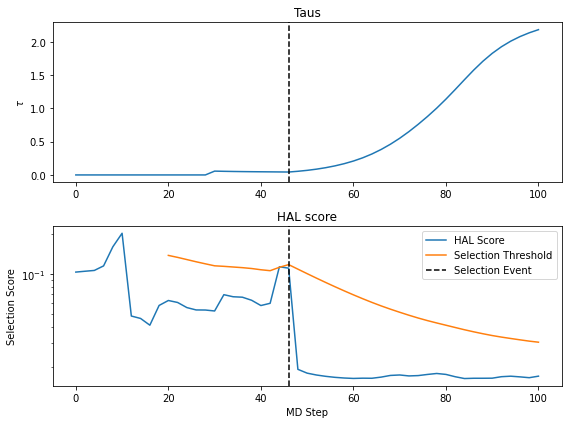

In [49]:
scores = [atoms.info["hal_score"] for atoms in ats_list]
taus = [atoms.info["tau"] for atoms in ats_list]
thresholds = [atoms.info["thresh"] for atoms in ats_list]

selections = []

score_peak = -np.inf

for i in range(len(ats_list)):
    if scores[i] > thresholds[i] and thresholds[i] < np.inf:
        score_peak = scores[i]
    elif score_peak > 0:
        selections.append(2*i)
        score_peak = -np.inf

Ns = [2*i for i in range(len(ats_list))]

fig, ax = plt.subplots(2, figsize=(8, 6))

ax[0].set_title("Taus")
ax[1].set_title("HAL score")

ax[0].plot(Ns, taus)

ax[1].plot(Ns, scores, label="HAL Score")
ax[1].plot(Ns, thresholds, label="Selection Threshold")

ax[0].axvline(selections, color="k", linestyle="dashed")
ax[1].axvline(selections, color="k", linestyle="dashed", label="Selection Event")

ax[1].legend()
ax[1].set_xlabel("MD Step")
ax[1].set_ylabel("Selection Score")
ax[0].set_ylabel(r"$\tau$")
ax[1].set_yscale("log")


plt.tight_layout()

plt.show()

We see from the plot that after the selection event, the HAL scores rapidly decrease. This is because after selection the committee is resampled based on the new information that the selected structure adds, which decreases the variance of committee weights. The tau value rises because the automatic determination aims to balance the newly decreased committee bias forces with the "mean forces" from the normal MPA model.